In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Paper_Implementations/Deep_Image_Prior

/content/drive/MyDrive/Paper_Implementations/Deep_Image_Prior


In [5]:
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 58.4 MB/s eta 0:00:00


In [10]:
os.getcwd()

'/content/drive/MyDrive/Paper_Implementations/Deep_Image_Prior'

In [22]:
import os
import yaml
import torch

from matplotlib import pyplot as plt
import numpy as np

from dip_core.utils.seeds import set_seed
from dip_core.utils.image_io import load_image
from dip_core.utils.losses import create_l2_loss
from dip_core.utils.metrics import PSNR
from dip_core.utils.debugging import Debugger
from dip_core.utils.plotting import plot_network, plot_tensor
from dip_core.utils.regularizers import TVRegularizer

from dip_core.networks.factory import DefaultNetworkFactory
from dip_core.training.default_training_step import DefaultTrainingStep
from dip_core.training.default_trainer import DefaultTrainer

from dip_core.base_implementations.default_operator import DefaultOperator
from dip_core.base_implementations.default_stopper import DefaultStopper
from dip_core.base_implementations.default_optimizer import DefaultOptimizerFactory

from dip_core.base_implementations.config_manager import ConfigManager
from dip_core.base_implementations.run_folder_manager import RunFolderManager

from experiments.denoising.denoising_logger import DenoisingLogger


CURRENT_DIR = os.getcwd()
LOG_DIR = os.path.join(CURRENT_DIR, "logs") # Adjusted for Colab environment
EXPERIMENT_NAME = 'denoising'
EXPERIMENT_DIR = os.path.join(CURRENT_DIR,"experiments", EXPERIMENT_NAME)


if __name__ == "__main__":
    print(LOG_DIR)

    # ------------------------------
    # 1. Load + validate config
    # ------------------------------

    template_path = os.path.join(EXPERIMENT_DIR, "config_template.yml")
    user_config_path = os.path.join(EXPERIMENT_DIR, "config_template.yml")
    log_dir = os.path.join(CURRENT_DIR, f"logs/{EXPERIMENT_NAME}")

    cfg_manager = ConfigManager(template_path)
    config = cfg_manager.load(user_config_path)

    cfg_manager.validate(config)

    # ------------------------------
    # 2. Prepare run folder
    # ------------------------------
    folder_mgr = RunFolderManager(exp_type=EXPERIMENT_NAME, log_dir=LOG_DIR)
    run_dir = folder_mgr.create_run_folder()
    folder_mgr.save_config(config, run_dir)

    # ------------------------------
    # 3. Set random seeds
    # ------------------------------
    set_seed(config["seed"])

    # ------------------------------
    # 4. Load data
    # ------------------------------
    gt = load_image(config["ground_truth_image"])
    noise = torch.randn_like(gt) * config["sigma"]/255.0
    noisy_image = gt + noise
    z = torch.randn(config["noise_shape"]) * config["std_inp_noise"]

    # plot_tensor(noisy_image)
    # plot_tensor(gt)
    # plot_tensor(z)

    # ------------------------------
    # 5. Build network
    # ------------------------------
    model = DefaultNetworkFactory().create_network(
        config["network"],
        config=config["description"]
    )

    # ------------------------------
    # 6. Move to GPU if needed
    # ------------------------------
    if config["use_gpu"] and torch.cuda.is_available():
        model = model.cuda()
        gt = gt.cuda()
        noisy_image = noisy_image.cuda()
        noise = noise.cuda()
        z = z.cuda()

    # ------------------------------
    # 7. Build training components
    # ------------------------------
    loss_fn = create_l2_loss()
    operator = DefaultOperator()
    stopper = DefaultStopper(config["iterations"])
    optimizer = DefaultOptimizerFactory(config["lr"]).create_optimizer(model.parameters())
    step_fn = DefaultTrainingStep()

    metrics = [PSNR()]
    logger = DenoisingLogger(gt, metrics_list=metrics, log_dir=run_dir)

    logger.save_config(config)
    logger.gt_metrics(noisy_image)

    # ------------------------------
    # 8. Run training
    # ------------------------------
    trainer = DefaultTrainer(
        model=model,
        training_step=step_fn,
        operator=operator,
        stopper=stopper,
        optimizer=optimizer,
        loss_fn=loss_fn,
        noise=noise,
        target=noisy_image,
        logger=logger,
        config=config,
        image_per=config["image_per"],
        regularizer=TVRegularizer(config["regularization_weight"])
    )

    # ------------------------------
    # 8. Run debuggings
    # ------------------------------


    plot_network(model)



    trainer.train()

/content/drive/MyDrive/Paper_Implementations/Deep_Image_Prior/logs
Could not plot network graph. inline plot: 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 512, 512]           1,216
         AvgPool2d-2         [-1, 16, 256, 256]               0
       BatchNorm2d-3         [-1, 16, 256, 256]              32
         LeakyReLU-4         [-1, 16, 256, 256]               0
            Conv2d-5         [-1, 16, 256, 256]           6,416
       BatchNorm2d-6         [-1, 16, 256, 256]              32
         LeakyReLU-7         [-1, 16, 256, 256]               0
            Conv2d-8         [-1, 32, 256, 256]          12,832
         AvgPool2d-9         [-1, 32, 128, 128]               0
      BatchNorm2d-10         [-1, 32, 128, 128]              64
        LeakyReLU-11         [-1, 32, 128, 128]               0
           Conv2d-12         [-1, 32, 128, 128]        

  4%|▍         | 376/10000 [00:15<06:42, 23.89it/s]


KeyboardInterrupt: 

In [20]:
def log_to_arr(dir):
  with open(dir) as f:
    content = f.readlines()

  arr = []
  for line in content:
    arr.append(float(line.split(": ")[-1]))

  return np.array(arr)


Subdirectories under /content/drive/MyDrive/Paper_Implementations/Deep_Image_Prior/logs/logs/denoising/runs:
2025-12-02_10-40-51


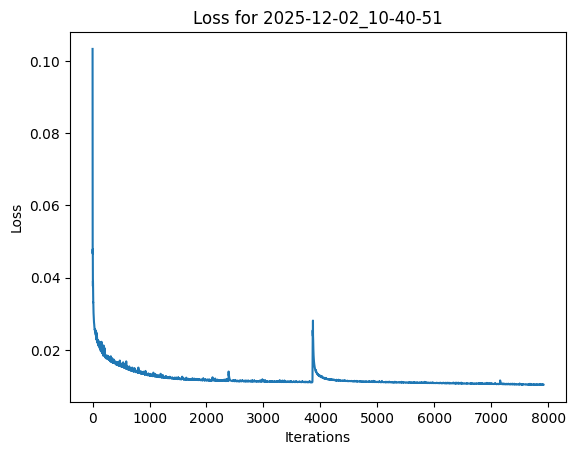

MAX LOSS: 0.10334687680006027
MIN LOSS: 0.010267955251038074


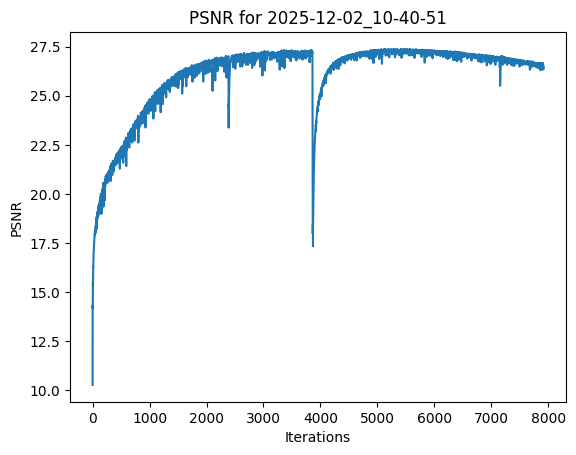

MAX PSNR: 27.384727478027344
MIN PSNR: 10.283002853393555
2025-12-04_11-57-17


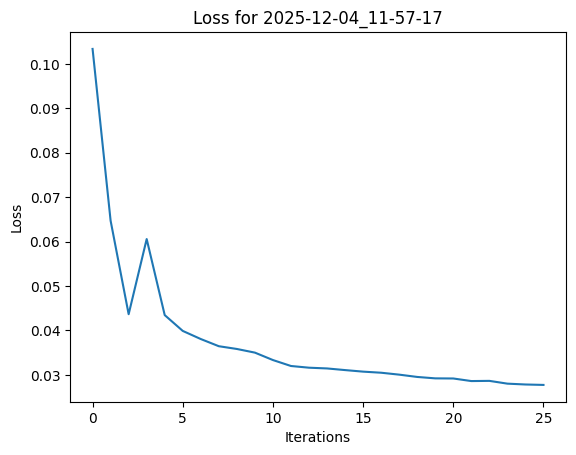

MAX LOSS: 0.10334689170122147
MIN LOSS: 0.027737634256482124


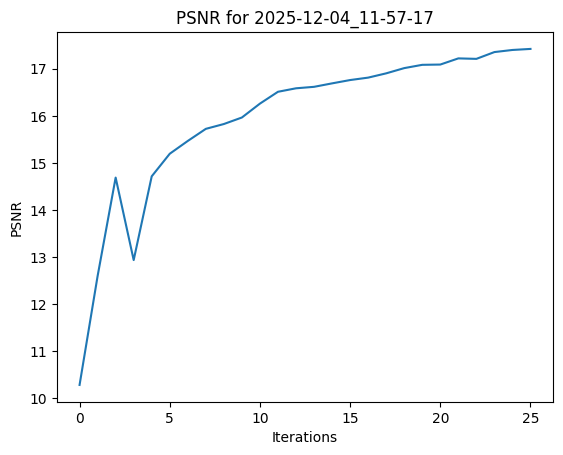

MAX PSNR: 17.42160415649414
MIN PSNR: 10.283002853393555
2025-12-14_04-10-58


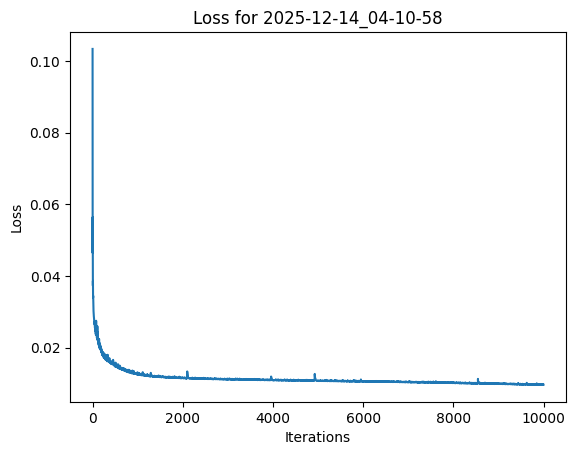

MAX LOSS: 0.10334687680006027
MIN LOSS: 0.009564843028783798


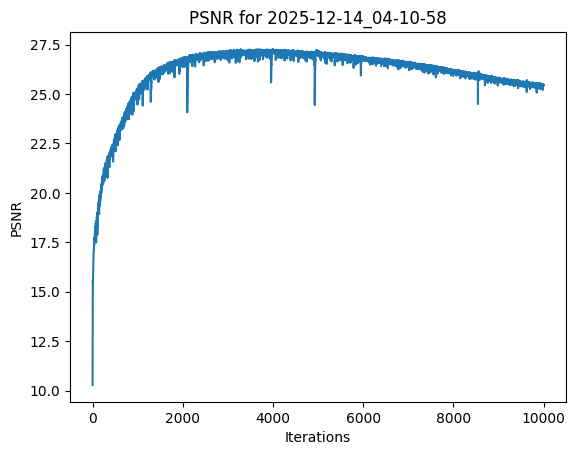

MAX PSNR: 27.282684326171875
MIN PSNR: 10.283002853393555
2025-12-14_04-27-31


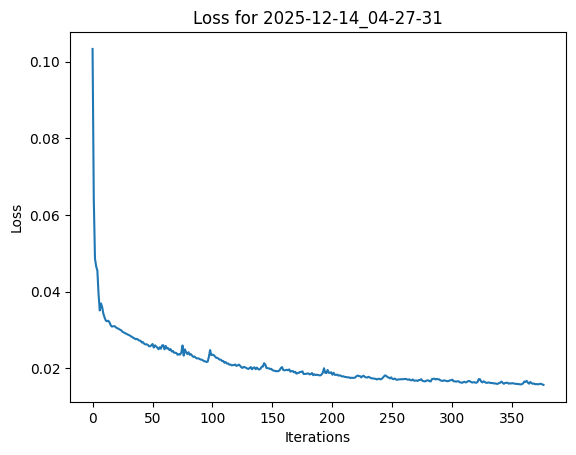

MAX LOSS: 0.10334687680006027
MIN LOSS: 0.015649808570742607


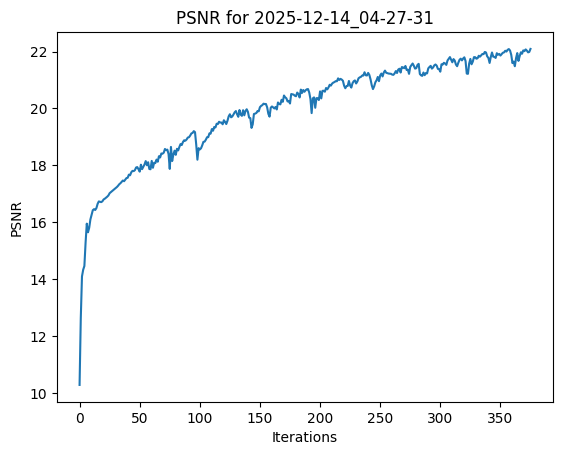

MAX PSNR: 22.094228744506836
MIN PSNR: 10.283002853393555


In [24]:
import os

base_path = '/content/drive/MyDrive/Paper_Implementations/Deep_Image_Prior/logs/logs/denoising/runs'

print(f"Subdirectories under {base_path}:")

# Check if the base path exists
if not os.path.exists(base_path):
    print(f"Error: The path '{base_path}' does not exist.")
else:
    subdirs = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]

    if subdirs:
        for subdir in subdirs:
            print(subdir)
            loss_arr = log_to_arr(os.path.join(base_path, subdir, "loss.txt"))
            plt.plot(loss_arr)
            plt.title(f"Loss for {subdir}")
            plt.xlabel("Iterations")
            plt.ylabel("Loss")
            plt.show()

            print(f"MAX LOSS: {np.max(loss_arr)}")
            print(f"MIN LOSS: {np.min(loss_arr)}")


            loss_arr = log_to_arr(os.path.join(base_path, subdir, "PSNR.txt"))
            plt.plot(loss_arr)
            plt.title(f"PSNR for {subdir}")
            plt.xlabel("Iterations")
            plt.ylabel("PSNR")
            plt.show()

            print(f"MAX PSNR: {np.max(loss_arr)}")
            print(f"MIN PSNR: {np.min(loss_arr)}")
    else:
        print("No subdirectories found.")

In [ ]:
log_to_arr()